In [1]:
2


2

In [74]:
import pandas as pd
import numpy as np
import requests
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle


In [75]:
# Load dataset
data = pd.read_csv("Merged.csv")

# View sample data
print(data.head(20))


                                              comment       tag
0   আলহামদুলিল্লাহ সোনার বাংলার সোনার ছেলেরা দেশকে...  Positive
1                                            মাশাল্লা  Positive
2                                           এগিয়ে যাও  Positive
3                                             চমৎকার।  Positive
4   দেশের শিল্প পতিদের উচিত দেশিও প্রযুক্তি গুলোকে...   Neutral
5                                      আলহামদুলিল্লাহ  Positive
6   সোনার ছেলেরাও পারে।এদের পাশে শিল্পপতিরা দাড়ালে...  Positive
7   সব ঠিক আছে।   কিন্তু ফোল চার্জ হতে কত সময় লাগব...  Positive
8                                      আলহামদুলিল্লাহ  Positive
9   প্রয়জন আবিষ্কারের জনক। 'পালকি' তে সোলার রিলেডে...  Positive
10  দাম মধ্যবিত্তদের নাগালে রাখার অনুরোধ রইলো পালি...  Positive
11  আমি না শুধু মন চাইলে আপনারা ও কিনতে পারেন একলা...   Neutral
12  দেশের এসব তরুণ উদ্যোক্তাদের জন্য রইলো অনেক অনে...  Positive
13  ভাই তাড়াতাড়ি বানান আমাদের দরকার অনেক অনেক অন...  Positive
14  ৩ লক্ষ টাকার মধ্যে রাখতে হবে না হলে 

In [76]:
# Check for missing values
print(data.isnull().sum())

# Drop missing values
data = data.dropna()


comment    0
tag        5
dtype: int64


In [77]:
# Correct common label typos
label_corrections = {
    "Neutural": "Neutral",
    "Meutral": "Neutral",
    "N EUTRAL": "Neutral",
    "NEUTRANEG": "Neutral",
    "Negetive": "Negative",
    "NEGNEG": "Negative",
    "Negativee": "Negative",
    "NEG": "Negative"
}

data['tag'] = data['tag'].replace(label_corrections)

# Remove the 'Neutral' class
data = data[data['tag'] != 'Neutral']


In [79]:
# Identify unique labels
print("Unique labels in dataset:", data['tag'].unique())

# Assume the first label is the positive class
positive_class_label = data['tag'].unique()[0]
positive_class = data[data['tag'] == positive_class_label]

# Reduce the count of the positive class
if len(positive_class) >= 10780:
    rows_to_remove = positive_class.sample(n=10780, random_state=42)
    data = data.drop(rows_to_remove.index)
else:
    print(f"Less than 10,000 positive rows available (found {len(positive_class)}).")


Unique labels in dataset: ['Positive' 'Negative']


In [81]:
# Load Bangla stopwords
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-bn/master/stopwords-bn.txt"
response = requests.get(stopwords_url)

if response.status_code == 200:
    stop_words_bangla = set(response.text.splitlines())
    
    # Remove stopwords
    data['comment'] = data['comment'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_bangla]))


In [82]:
# Define text and label columns
text_column = 'comment'
target_column = 'tag'

# Split data into training and test sets
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

# Tokenize text
max_sequence_length = 100  
max_features = 10000  
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_train[text_column])

# Convert text to sequences
X_train_text = tokenizer.texts_to_sequences(df_train[text_column])
X_test_text = tokenizer.texts_to_sequences(df_test[text_column])

# Apply padding
X_train_text = pad_sequences(X_train_text, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_text = pad_sequences(X_test_text, maxlen=max_sequence_length, padding='post', truncating='post')

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train[target_column])
y_test = label_encoder.transform(df_test[target_column])


In [90]:
# Define the ANN model
model = Sequential([
    Embedding(input_dim=max_features, output_dim=128, input_length=max_sequence_length),
    Flatten(),  # Flatten for ANN
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train_text, y_train, epochs=100, batch_size=32, validation_split=0.1)


Epoch 1/100


C:\Users\tonmo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5198 - loss: 0.7019 - val_accuracy: 0.5463 - val_loss: 0.6900
Epoch 2/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5413 - loss: 0.6907 - val_accuracy: 0.5463 - val_loss: 0.6897
Epoch 3/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5377 - loss: 0.6905 - val_accuracy: 0.5463 - val_loss: 0.6897
Epoch 4/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5494 - loss: 0.6886 - val_accuracy: 0.5478 - val_loss: 0.6888
Epoch 5/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5386 - loss: 0.6900 - val_accuracy: 0.5463 - val_loss: 0.6896
Epoch 6/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5388 - loss: 0.6900 - val_accuracy: 0.5463 - val_loss: 0.6920
Epoch 7/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5338 - loss: 0.6893 - val_accuracy: 0.5468 - val_loss: 0.6935
Epoch 8/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5442 - loss: 0.6882 - val_accuracy

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


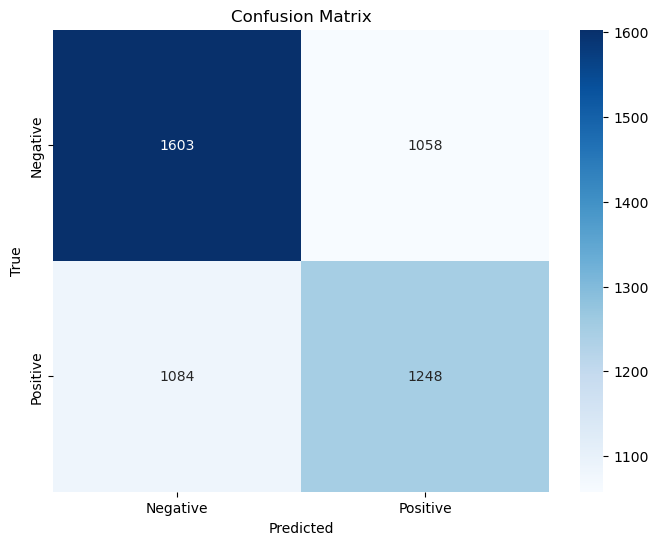

In [85]:
# Predict on test data
test_preds = model.predict(X_test_text)
predicted_labels = test_preds.argmax(axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [86]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, predicted_labels, zero_division=0))


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60      2661
           1       0.54      0.54      0.54      2332

    accuracy                           0.57      4993
   macro avg       0.57      0.57      0.57      4993
weighted avg       0.57      0.57      0.57      4993



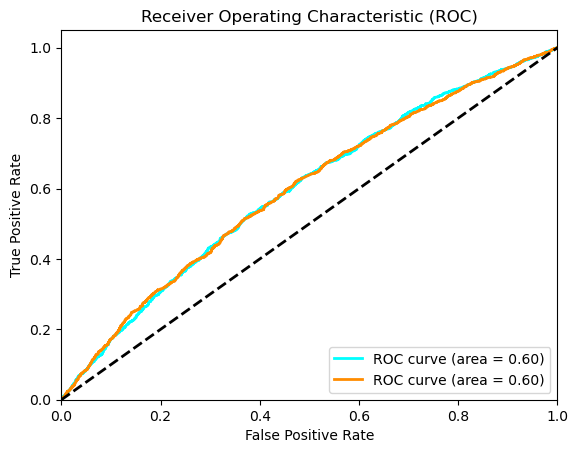

In [87]:
# Convert labels to one-hot encoding
n_classes = len(label_encoder.classes_)
y_bin = tf.one_hot(y_test, n_classes)

# Compute ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


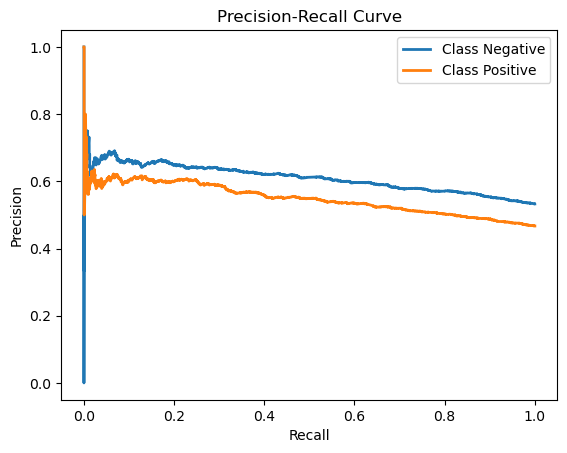

In [88]:
# Compute Precision-Recall curve
plt.figure()
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], test_preds[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {label_encoder.classes_[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
